<a href="https://colab.research.google.com/github/Somertonman/hackathon_2023/blob/main/graph_org.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
#%%capture
!pip install stanza python-docx pymorphy2 matplotlib nltk networkx docx tqdm spicy


In [54]:
import pandas as pd
import spacy
from tqdm import tqdm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
!python -m spacy download ru_core_news_lg

# Data source

In [ ]:
!wget https://github.com/Somertonman/hackathon_2023/raw/main/all_parsed_graph.csv

In [ ]:
df = pd.read_csv('all_parsed_graph.csv')
df = df.query('name != "себя"').reset_index().drop(columns='index')
df = df[['id', 'task_num',
       'task_text', 'dept', 'task_responsibles_people', 'task_deadline',
       'position', 'name', 'global_deadline', 'Tasks']]
df.head()

In [27]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian") 

def Convert(string): 
    li = list(string.split(" ")) 
    return li 

def stem(text):
  my_words = Convert(text)
  l = []
  for word in my_words:
    if word != "специалист":
        l.append(stemmer.stem(word))
  return " ".join(l)

In [28]:
df['position'] = df.apply(lambda x: stem(x['position']), axis=1)

In [29]:
df['position']

0       перв категор административно-хозяйствен отдел
1                               трет категор служб ит
2                               системн администратор
3                                        трет категор
4                     контрол над исполнен распоряжен
                            ...                      
2864    перв категор административно-хозяйствен отдел
2865     руководител административно-хозяйствен отдел
2866    перв категор административно-хозяйствен отдел
2867     руководител административно-хозяйствен отдел
2868     руководител административно-хозяйствен отдел
Name: position, Length: 2869, dtype: object

In [ ]:
# https://drive.google.com/file/d/1GIak7jmxhucwpr4VAJxEniinMwOmObPv/view?usp=sharing
!gdown 1GIak7jmxhucwpr4VAJxEniinMwOmObPv

In [ ]:
!mkdir json_dataset
!tar -xvf  '/content/json.tar' -C '/content/json_dataset'

In [ ]:
def parse_file(file_name, num):
  df = pd.read_json(file_name).reset_index()

  df['id'] = num

  df = df.query('index not in ("Global_deadline", "Global_supervisor")')
  df['task_text'] = df.apply(lambda x: x['Tasks']['task_text'], axis = 1)
  df['task_responsibles_people'] = df.apply(lambda x: x['Tasks']['task_responsibles_people'], axis = 1)
  df['task_responsibles_groups'] = df.apply(lambda x: x['Tasks']['task_responsibles_groups'], axis = 1)

  df = df[['id', 'index', 'task_responsibles_groups', 'task_responsibles_people']]
  return df.rename(columns={'index':'task_num', 'task_responsibles_groups':'dept'})

In [ ]:
df_emp = parse_file('/content/json_dataset/json/0.json', 0)

for i in tqdm(range (1, 10000)):
  file_name = f"/content/json_dataset/json/{i}.json"
  df_one = parse_file(file_name, i)
  df_emp = pd.concat([df_emp, df_one])

df_emp['task_responsibles_people'] = df_emp['task_responsibles_people'].str.lower()
df_emp = df_emp.reset_index().drop(columns=['index'])
df_emp.head()

In [ ]:
df_emp['name'] =  df_emp.apply(lambda x : ' '.join([ent.text for ent in nlp(x.task_responsibles_people).ents]), axis = 1)
df_emp.head()

# Data cleaning

In [30]:
df.fillna(0, inplace = True)
df.replace('None', 0, inplace = True)


In [31]:
import stanza
from stanza.models.common.doc import Document

nlp = stanza.Pipeline(lang='ru', processors='tokenize,lemma', lemma_pretagged=True, tokenize_pretokenized=True)
doc = nlp('специалист третий категория')
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')



INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| lemma     | syntagrus |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


word: специалист 	lemma: специалист
word: третий 	lemma: третий
word: категория 	lemma: категория


In [32]:
doc = nlp('специалист третий категория')
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')


word: специалист 	lemma: специалист
word: третий 	lemma: третий
word: категория 	lemma: категория


# EDA

In [33]:
# some basic stats

documents = df['id'].unique()
departments = df['dept'].unique()
employees = df['name'].unique()
positions = df['position'].unique()


print('Number of docs:', len(documents))
print('Number of depts in the company:', len(departments) )
print('Number of employees in the company:', len(employees))
print('Number of positions in the company total:', len(positions))

Number of docs: 620
Number of depts in the company: 8
Number of employees in the company: 59
Number of positions in the company total: 46


## How many documents was analyzed?

In [34]:
print(documents)

[  0   1   2  12  13  14  15  16  17  18  19  20   3   4   5   6   7   8
   9  10  11  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 204 205 206 207 208 209 210 211 212 213 214 215 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 24

## Company departments

In [35]:
print(departments)

['Административно-хозяйственный отдел' 'Служба ИТ'
 'Отдел разработки систем' 'Отдел архитектуры' 'Бухгалтерия'
 'Отдел проектирования' 'Отдел эксплуатации' 'Отдел тестирования']


## Employees

In [36]:
print(employees)

['кравцов и.е.' 'ким юрий иванович' 'сергеев андрей' 'абаимов симон'
 'абаимов симона' 'абашкин орест' 'абалкин зураб' 'андреев с.е.'
 'слесарев а.в' 'абатуров борис' 'миронов к.а.' 'симоново н.с.'
 'абаковый алексей' 'попов а.а.' 'никишин с.е.' 'абашичев алексей'
 'с.с.галкин' 'сергеев ален иванович' 'поспелов н.а.' 'миронов т.п.'
 'александров а.с.' 'семёнов м.с.' 'миронов' 'семёнов' 'семёнов и.а.'
 'попов и.и.' 'коптеловый е.в' 'кравцов' 'смирнов о.а.' 'шихов'
 'шихов р.п.' 'абакуловый пётр' 'абалаково севастьян' 'ведерников и.с.'
 'жуков а.в' 'точновый' 'иванов а.а.' 'р.е.артюхин'
 'александров александр иванович' 'абалаковый севастьян' 'абалдуев олег'
 'петров в.м.' 'никитин ирина петрович' 'андреев к.с.' 'абалакин михаил'
 'сергеев алёна иванович' 'петров' 'абакумов глеб' 'абаков алексей'
 'симонов н.с.' 'львов' 'анненков' 'спецова а.в' 'львов а.м.'
 'анненков и.с.' 'янина и.а.' 'точновое с.о.' 'янин и.а.' 'спецов а.в']


In [ ]:
emp_dictionary = { emp : emp for emp in employees }
emp_dictionary['янина и.а.'] = 'янин и.а.'
emp_dictionary['ким юрий иванович'] = 'ким ю.и.'
emp_dictionary['абаимов симона'] = 'абаимов с.'
emp_dictionary['абаимов симон'] = 'абаимов с.'
emp_dictionary['сергеев андрей'] = 'сергеев а.'
emp_dictionary['абашкин орест'] = 'абашкин о.'
emp_dictionary['абалкин зураб'] = 'абалкин з.'
emp_dictionary['абатуров борис'] = 'абатуров б.'
emp_dictionary['симоново н.с.'] = 'симонов н.с.'
emp_dictionary['абаковый алексей'] = 'абаков а.'
emp_dictionary['абашичев алексей'] = 'абашичев а.'
emp_dictionary['с.с.галкин'] = 'галкин c.c.'
emp_dictionary['сергеев ален иванович'] = 'сергеева а.и.'
emp_dictionary['семёнов'] = 'семёнов и.а.'
emp_dictionary['кравцов'] = 'кравцов и.е.'
emp_dictionary['шихов'] = 'шихов р.п.'
emp_dictionary['абакуловый пётр'] = 'абакулов п.'
emp_dictionary['абалаково севастьян'] = 'абалаков с.'
emp_dictionary['артюхин'] = 'артюхин р.е.'
emp_dictionary['александров александр иванович'] = 'александров а.и.'
emp_dictionary['абалаковый севастьян'] = 'абалаков с.'
emp_dictionary['абалдуев олег'] = 'абалдуев о.'
emp_dictionary['никитин ирина петрович'] = 'никитина и.п.'
emp_dictionary['абалакин михаил'] = 'абалакин м.'
emp_dictionary['сергеев алёна иванович'] = 'сергеева а.и.'
emp_dictionary['петров'] = 'петров в.м.'
emp_dictionary['львов'] = 'львов а.м.'
emp_dictionary['абаков алексей'] = 'абаков а.'
emp_dictionary['анненков'] = 'анненков и.с.'
emp_dictionary['точновый'] = 'точнов с.о.'
emp_dictionary['спецова а.в'] = 'спецов а.в'
emp_dictionary['миронов'] = 'миронов т.п'
emp_dictionary['семёнов'] = 'миронов и.а'
emp_dictionary['коптеловый е.в'] = 'коптелов е.в'
emp_dictionary['точновое с.о.'] = 'точнов с.о.'
emp_dictionary['р.е.артюхин'] = 'артюхин р.е.'

In [ ]:
df['name'] = df['name'].map(emp_dictionary)

# Graph

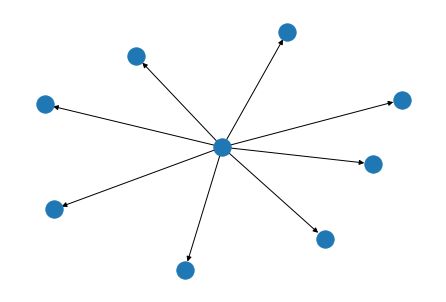

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

DG = nx.DiGraph()

comp_name = 'COMPANY'

for i in list(departments):
    DG.add_edge(comp_name, i)
    

nx.draw(DG)


## Multilevel graph

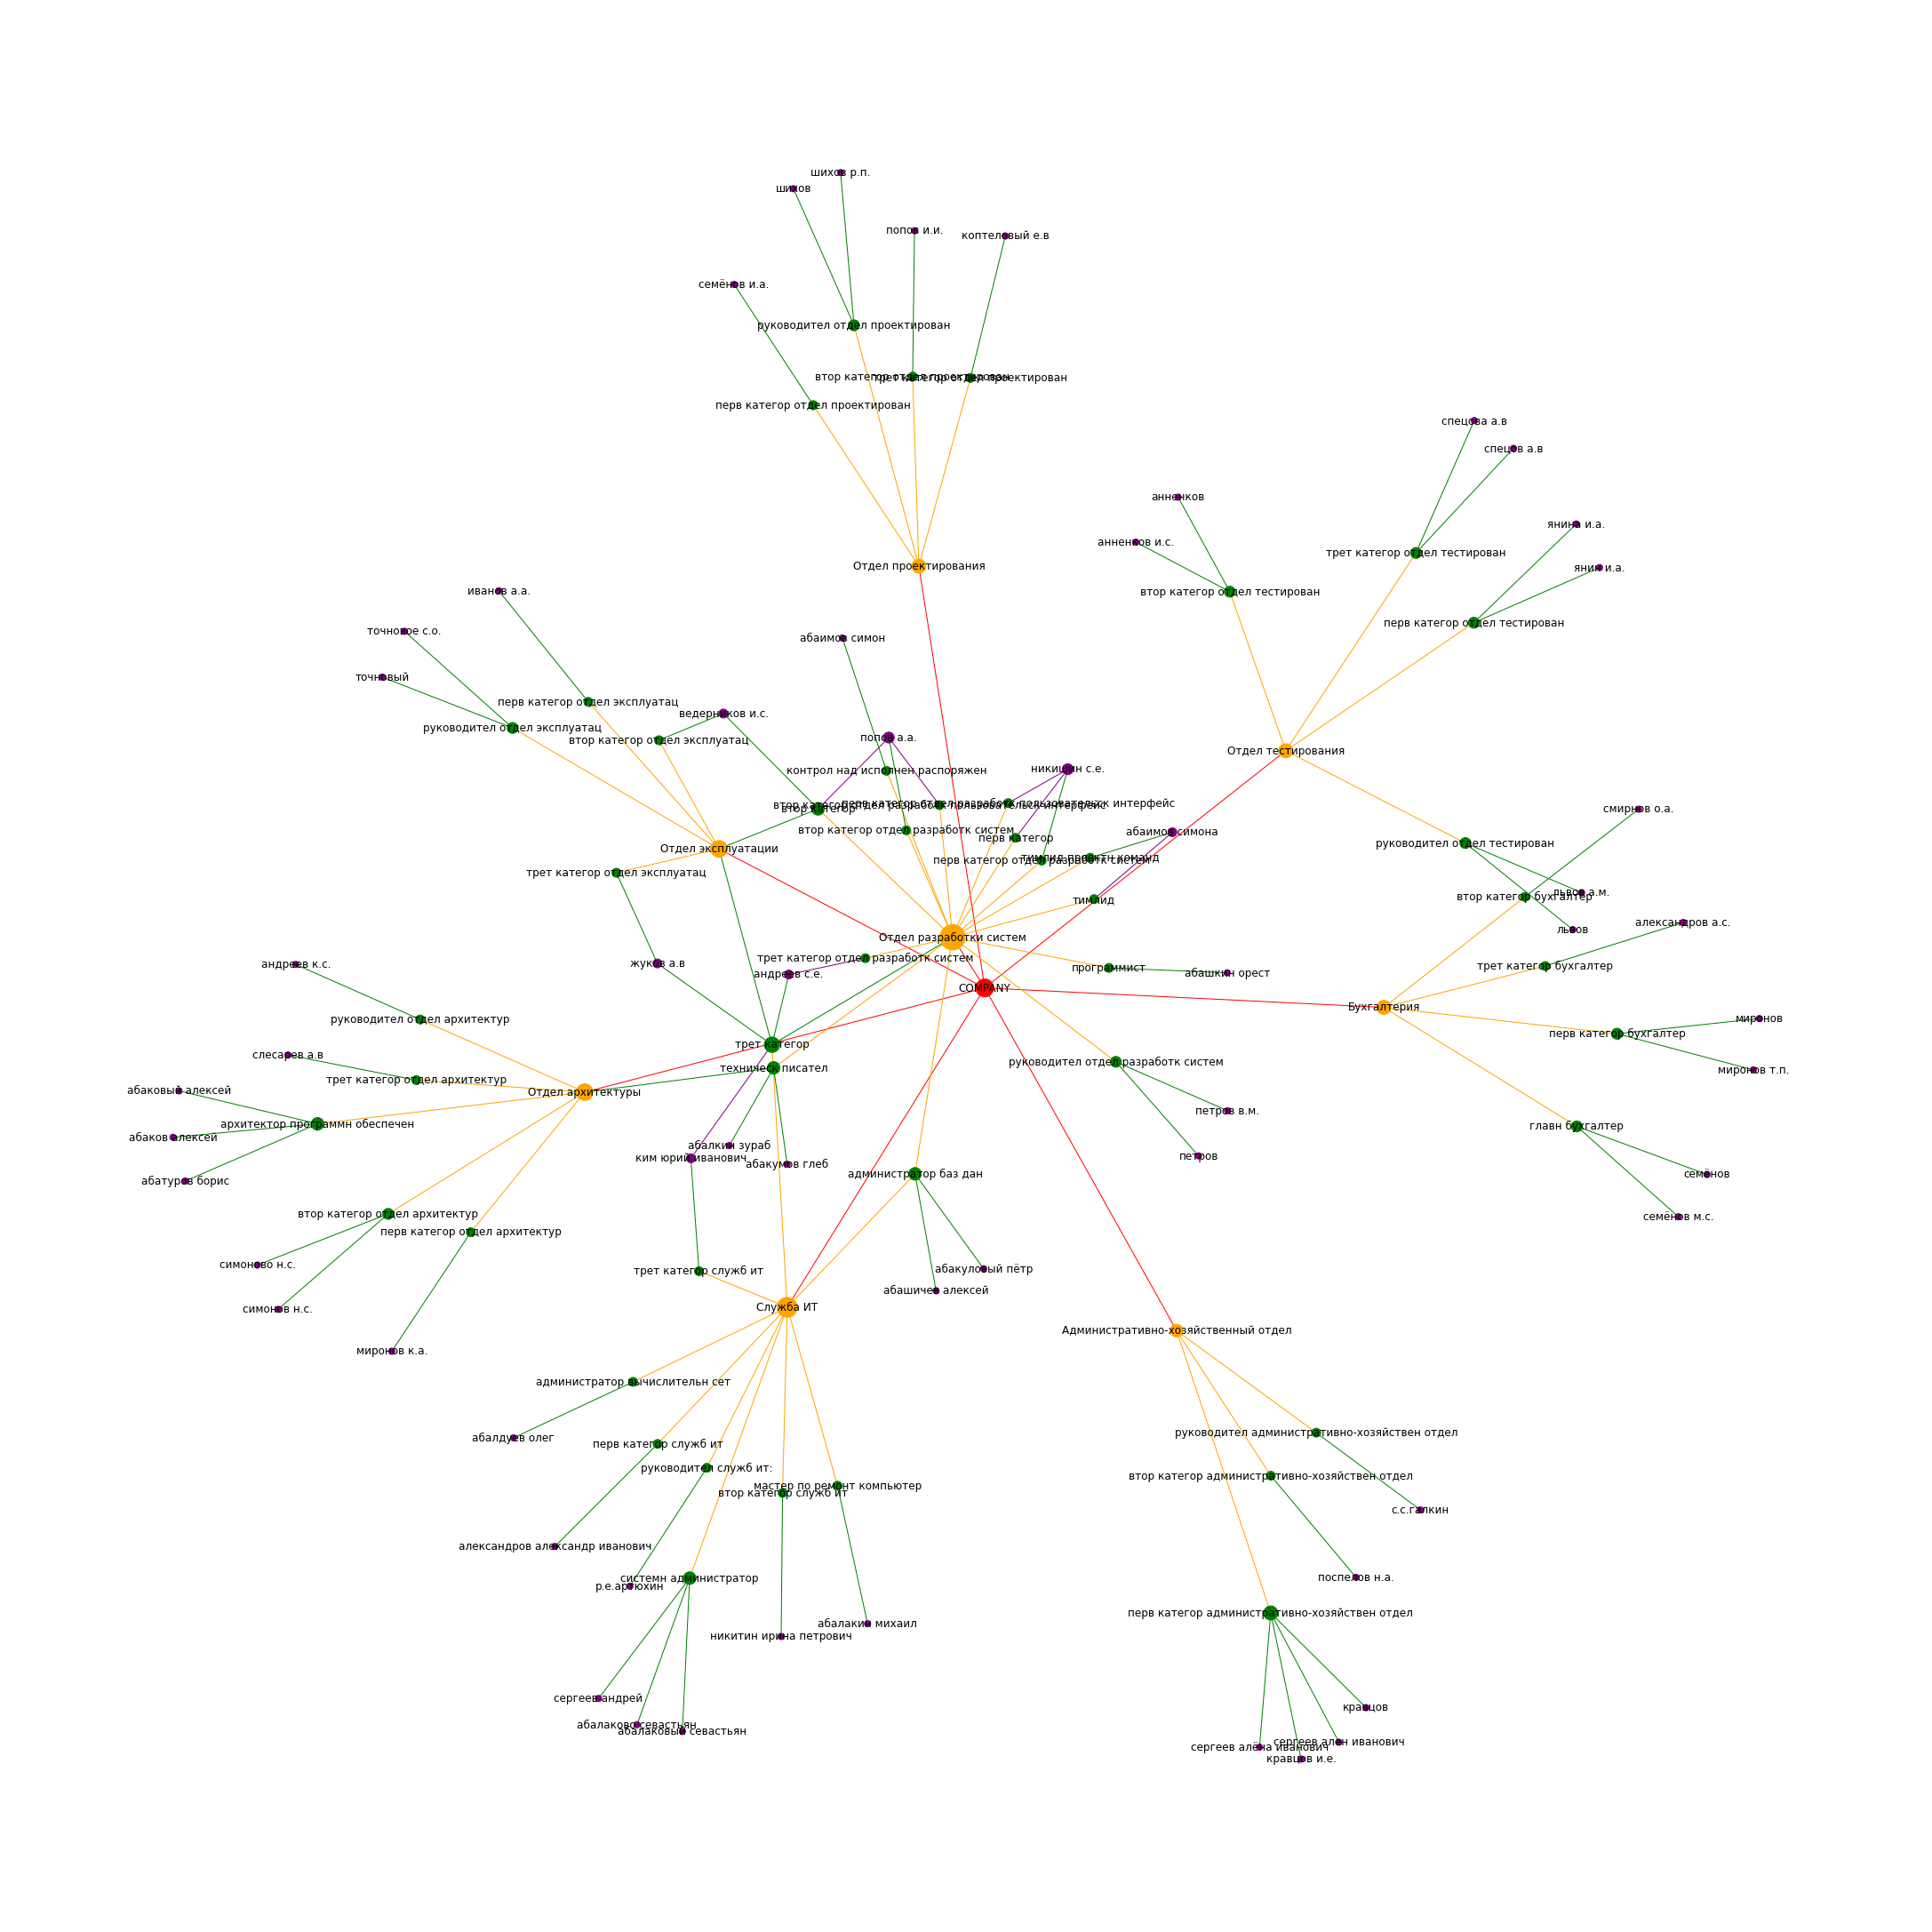

In [38]:
# create a graph object
G = nx.Graph()

comp_name = 'COMPANY'

for z in list(departments):
    G.add_edge(comp_name, z)
    # iterate through the rows of the DataFrame
    for i, row in df.iterrows():
        # add task_responsibles_groups node
        dept = row["dept"]
        G.add_node(dept, size=df["dept"].value_counts()[dept])
        # add position node
        position = row["position"]
        G.add_node(position, size=df["position"].value_counts()[position])
        # add name node
        name = row["name"]
        G.add_node(name, size=df["name"].value_counts()[name])
        # add edges between task_responsibles_groups and position
        G.add_edge(dept, position)
        # add edges between position and name
        G.add_edge(position, name)

# draw the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
pos = nx.spring_layout(G) # spring layout to calculate node positions

# create a list of node sizes
node_sizes = []
for node in G.nodes():
    node_sizes.append(G.degree(node)*50)

# create a list of node colors
node_colors = []
for node in G.nodes():
    if node in departments:
        node_colors.append("orange")
    elif node in df["position"].unique():
        node_colors.append("green")
    elif node in df["name"].unique():
        node_colors.append("purple")
    else:
        node_colors.append("red")

# create a list of edge colors
edge_colors = []
for edge in G.edges():
    if edge[0] in departments:
        edge_colors.append("orange")
    elif edge[0] in df["position"].unique():
        edge_colors.append("green")
    elif edge[0] in df["name"].unique():
        edge_colors.append("purple")
    else:
        edge_colors.append("red")

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color=edge_colors)


# Document checker

In [48]:
from google.colab import files

!test -d docx_for_check || mkdir docx_for_check

uploaded = files.upload()

print('uploaded to the "/content" folder')


Saving 9920.docx to 9920.docx
uploaded to the "/content" folder


## Parsing text from docx files

In [44]:
from docx import Document
import os
import random

def get_text(filename):
    doc = Document(f'/content/{filename}')
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

folder_path = '/content'
docx_files = [f for f in os.listdir(folder_path) if f.endswith('.docx')]
random_file = random.choice(docx_files)

text = get_text(random_file)
if docx_files:
    random_file = random.choice(docx_files)
    text = get_text(random_file)
    print(text)
else:
    print("No docx files found in the directory")



ООО "Мегасофт"


Приказ
Для организации мероприятия "День заказчика" приказываю:
○
Доработать функцию сохранения информации в базу данных. Срок завершения: 27.12.2012.
Обеспечение выполнения возложить на специалиста первой категории отдела разработки пользовательских интерфейсов Никишина С.Е.
○ Провести анализ неисправности работы API и обеспечить устранение ошибки.
Дата окончания: 20.01.21.
За контроль над исполнением распоряжения назначить ответственным специалиста первой категории отдела разработки систем Никишина С.Е.
○
Использовать автоматизированное тестирование перед сборкой системы.
Определить срок исполнения задачи вплоть до 22 апр 2019 г..
Контроль над исполнением распоряжения оставить за специалистом первой категории отдела разработки пользовательских интерфейсов Никишиным С.Е.
	i) Разработать коннектор для интеграции со сторонним программным обеспечением.
Определить срок исполнения задачи вплоть до 21.07.18.
За контроль и выполнение назначить ответственным администратора б

### Check a given name and position on the graph

In [51]:
import pymorphy2
def is_name_position_in_graph(G, name, position):
    if not name and not position:
        return False
    morph = pymorphy2.MorphAnalyzer()
    if name:
        name_norm = morph.parse(name)[0].normal_form
    if position:
        position_norm = morph.parse(position)[0].normal_form

    for node in G.nodes():
        if name:
            node_norm = morph.parse(node)[0].normal_form
            if node_norm != name_norm:
                continue
        if position:
            neighbors = G.neighbors(node)
            for neighbor in neighbors:
                neighbor_norm = morph.parse(neighbor)[0].normal_form
                if neighbor_norm == position_norm:
                    return True
    return False


In [52]:
name = ''
position = 'главн бухгалтер'
print(is_name_position_in_graph(G, name, position))

True


# Graph finding paths

In [ ]:
results = []
for n1 in G.nodes():
    for n2 in G.nodes():
        shortest_path = nx.single_source_dijkstra(G, source=n1, target=n2)
        results.append(shortest_path)


In [ ]:
shortest_path = nx.single_source_dijkstra(G, source='ведерников и.с.', target='COMPANY')
print(shortest_path)


# SPACY

In [ ]:
!python -m spacy download ru_core_news_lg


In [ ]:
import spacy
nlp = spacy.load('ru_core_news_lg')


# Helper functions

In [ ]:
shortest_path = nx.single_source_dijkstra(G, source='ведерников и.с.', target='COMPANY')
print(shortest_path)

Is a given person works in the company

In [ ]:
def is_employee(graph, company, name):
  try:
    shortest_path = nx.single_source_dijkstra(G, source=company, target=name)
    print(shortest_path)
    if shortest_path[0] == 3 and shortest_path[1][-1] == name:
      return True
    else:
      return False
  except:
    return False

is_employee(G, 'COMPANY', 'ведерников и.с.')

In [ ]:
is_employee(G, 'COMPANY', 'абатуров борис')

Is a given person works in the company

In [ ]:
def is_employee_to_dept(graph, company, dept, name):
  try:
    shortest_path = nx.single_source_dijkstra(G, source=company, target=name)
    print(shortest_path)
    if shortest_path[0] == 3 and shortest_path[1][1] == dept:
      return True
    else:
      return False
  except:
    return False


is_employee_to_dept(G, 'COMPANY', 'Отдел эксплуатации', 'ведерников и.с.')

In [ ]:
is_employee_to_dept(G, 'COMPANY', 'Отдел эксплуатации', 'абатуров борис')

In [ ]:
results = []
for n1 in G.nodes():
    for n2 in G.nodes():
        shortest_path = nx.single_source_dijkstra(G, source=n1, target=n2)
        results.append(shortest_path)


In [ ]:
#[x for x in results if x[0] != 3]